In [1]:
# Import liberaries and functions
import pandas as pd
import numpy as np
import re
import pickle

In [2]:
topics_df = pd.read_csv("Data/RF_text_attr.csv", parse_dates=['report_dt', 'filing_dt'], index_col=0)

companies = pd.read_csv('Data/all_companies.csv')
topics_df = pd.merge(left=topics_df, right=companies[["SIC", "FF"]].drop_duplicates(), on="SIC", how='left')

topics_df["FF"] = topics_df["FF"].fillna(48).astype(int)

topics_df.fillna({'FOG':1}, inplace=True)

In [3]:
# # Add the reduced topic clusters (topic cluster for every risk topic) 
# with open("Top2Vec\\topic_hierarchy.txt", 'rb') as f:
#     TH = pickle.load(f)

# df = pd.DataFrame(TH).reset_index()

# TH = (
#     pd.melt(df, id_vars=['index'])
#     .dropna()
#     .astype(int)
#     .sort_values(['index', 'value'])
#     .drop(columns='variable')
# )

# topics_df['Topic_H'] = pd.merge(
#     left=topics_df,
#     right=TH[['index', 'value']],
#     left_on=['Topic'],
#     right_on=['value'],
#     how='left'
# )['index'].drop(columns=['index', 'value'])

# Stats

In [4]:
# Use historical SIC data (from Cumpustat) for industry analysis
sich = pd.read_csv(
    filepath_or_buffer="Data\Financials.csv",
    decimal=".", 
    thousands=',',
    usecols=[
        'cik', 'datadate', 'sich'
    ]
).drop_duplicates()

sich.sort_values(['cik', 'datadate'], inplace=True)
sich["datadate"] = pd.to_datetime(sich["datadate"], format="%d/%m/%Y")

topics_df = pd.merge(
    left=topics_df,
    right=sich[[
        'cik', 'datadate', 'sich']],
    left_on=["CIK", "report_dt"],
    right_on=["cik", "datadate"],
    how="left"
).drop(columns=['datadate', 'cik'])

topics_df['sich'] = topics_df['sich'].fillna(topics_df['SIC']).astype(int)

In [5]:
# First 2 digits of SIC -> Major sector group
topics_df['SIC2'] = topics_df['sich'].map(lambda x: f"{int(x):04d}"[:2])

topics_df['SIC3'] = topics_df['sich'].map(lambda x: f"{int(x):04d}"[:3])

In [6]:
# Aggregate the records at the CIK-year level
agg_tops = (
    topics_df.groupby(["CIK", "report_dt", "filing_dt", "FF"])[
        ['rprt_length', 'SIC3', 'Pa', 'Pr', 'Fu', 'Sentiment', 'FOG', 'sich']
    ]
    .agg({
        'rprt_length': 'sum',
        'Pa': 'sum',
        'Pr': 'sum', 
        'Fu': 'sum',
        'Sentiment': 'mean',
        'FOG': 'mean',
        'SIC3' : 'unique', 
        'sich' : 'unique'
    }).reset_index()
).drop_duplicates(subset=["CIK", "filing_dt", "report_dt"]).sort_values(["CIK", "report_dt", "filing_dt"])

In [7]:
agg_tops['Delta_length'] = agg_tops['rprt_length'] - agg_tops.groupby('CIK')['rprt_length'].shift(1)
agg_tops["SIC3"] = agg_tops["SIC3"].map(lambda x: x[0])
agg_tops["sich"] = agg_tops["sich"].map(lambda x: x[0])

In [8]:
# Risk factor clusters disclosed and not disclosed per report 
disc_df = pd.pivot_table(
    topics_df, index = ["CIK", "filing_dt", "report_dt", "FF"], 
    columns='Topic', values='Score'
).notna().astype(int).reset_index().sort_values(["CIK", "filing_dt", "report_dt"])


In [9]:
# Long format for disclosure dataframe
disc_long = pd.melt(disc_df, id_vars=["CIK", "filing_dt", "report_dt"], value_name='disclosed')

# How many times the disclosed risk factor have appeared in the firm report over the years
disc_long['DiscSum'] = disc_long.groupby(["CIK", 'Topic'])['disclosed'].cumsum()

DiscSum = disc_long[disc_long['disclosed']>0].groupby(['CIK', 'filing_dt', 'report_dt'])['DiscSum'].mean()

# Add cumulative disclosure variable to the main dataframe
agg_tops = pd.merge(
    left=agg_tops,
    right=DiscSum.reset_index(),
    on=['CIK', 'filing_dt', 'report_dt'],
    how='left'
)

## Variables for H1

In [10]:
# Difference between disclosed risk topics in 2 consecutive years
disc_diff = disc_df.filter(range(0,3770)) - disc_df.groupby("CIK")[disc_df.filter(range(0,3770)).columns].shift(1)

# Repeated risk factors
disc_repeat = (
    disc_df.filter(range(0,3770))
    + disc_df.groupby("CIK")[disc_df.filter(range(0,3770)).columns].shift(1) 
    == 2
).astype(int)

In [11]:
# Number of added, repeated and removed individual topics
disc_df["reported_crnt"] = disc_df.filter(range(0,3770)).sum(axis=1)
disc_df["reported_last"] = disc_df.groupby("CIK")['reported_crnt'].shift(1)
disc_df["repeated"] = disc_repeat[disc_repeat>0].sum(axis=1)
disc_df["added"] = disc_diff[disc_diff>0].sum(axis=1)
disc_df["removed"] = disc_diff[disc_diff<0].sum(axis=1)

In [12]:
stat_data = pd.merge(
    left=agg_tops,
    right=disc_df[['CIK', 'filing_dt', 'report_dt', 'FF', 
                   'reported_crnt', 'reported_last', 'repeated', 'added', 'removed']],
    on=['CIK', 'filing_dt', 'report_dt', 'FF'],
    how='left'
)

In [13]:
# Number of days from fiscal year end and actual filing date
stat_data['rfGap'] = (stat_data['filing_dt'] - stat_data['report_dt']).dt.days

stat_data['fyear'] = stat_data['filing_dt'].dt.year
stat_data['ryear'] = stat_data['report_dt'].dt.year

In [14]:
# Average change of the score for repeated RFs --> amount updated
# Score of disclosed risk topics per report 
disc_score_df = pd.pivot_table(
    topics_df, index = ["CIK", "filing_dt", "report_dt"], 
    columns='Topic', values='Score'
).reset_index().sort_values(["CIK", "filing_dt", "report_dt"])

disc_score_diff = (disc_score_df.filter(range(0,3770)) - disc_score_df.groupby("CIK")[disc_score_df.filter(range(0,3770)).columns].shift(1)).abs()

stat_data['ScoreChng'] = disc_score_diff.multiply(disc_repeat).mean(axis=1)

In [15]:
# Drop first year of observations
stat_data.dropna(subset=['Delta_length', 'reported_last'], inplace=True)

In [16]:
# SIC code of high-tech and regulated industries (Kothari, 2009)
high_tech = []
high_tech.extend(range(2833, 2837))
high_tech.extend(range(3570, 3578))
high_tech.extend(range(3600, 3675))
high_tech.extend(range(7371, 7380))
high_tech.extend(range(8731, 8735))

regulated = [4812, 4813, 4833, 4841, 4922, 4923, 4924, 4931, 4941]
regulated.extend(range(4811, 4900))


stat_data['high_tech'] = stat_data['sich'].isin(high_tech).astype(int)
stat_data['regulated'] = stat_data['sich'].isin(regulated).astype(int)

## Variables for H2

In [17]:
# Counting the actual number of firms per industry (using all-submissions from EDGAR)
filings_df = pd.read_csv("Data\\filings_df.csv", parse_dates=["filingDate", "reportDate"])

filings_df.dropna(subset=["filingDate", "reportDate", "sic"], inplace=True)

filings_df = filings_df.sort_values(['cik', 'reportDate', 'filingDate']).drop_duplicates(keep='last')

# Use historical SIC data for industry analysis
filings_df = pd.merge(
    left=filings_df,
    right=sich[[
        'cik', 'datadate', 'sich']],
    left_on=["cik", "reportDate"],
    right_on=["cik", "datadate"],
    how="left"
).drop(columns=['datadate'])

filings_df['sich'] = filings_df['sich'].fillna(filings_df['sic']).astype(int)
filings_df['SIC2'] = filings_df['sich'].map(lambda x: f"{int(x):04d}"[:2])
filings_df['SIC3'] = filings_df['sich'].map(lambda x: f"{int(x):04d}"[:3])

filings_df = pd.merge(
    left=filings_df, right=companies[["SIC", "FF"]].drop_duplicates(), 
    left_on="sich", right_on="SIC", how='left'
).drop(columns="SIC")

filings_df["FF"] = filings_df["FF"].fillna(48).astype(int)

In [18]:
# Risk topics disclosed and not disclosed per report 
disc_df = pd.pivot_table(
    topics_df, index = ["CIK", "filing_dt", "report_dt", "FF"], 
    columns='Topic_H', values='Score'
).notna().astype(int).reset_index()

disc_df.sort_values(['CIK', 'report_dt', 'filing_dt'], inplace=True)

disc_df["filing_dt-1"] = disc_df["filing_dt"] - pd.Timedelta(weeks=52)

In [19]:
filings_df = filings_df[
    (filings_df["filingDate"] >= disc_df['filing_dt'].min())
    &(filings_df["filingDate"] <= disc_df['filing_dt'].max())
]
filings_df['fyear'] = filings_df["filingDate"].dt.year

# Number of reporting firms per year per industry
cnt_firms = filings_df.groupby(['FF', 'fyear'])['filingDate'].nunique().reset_index()

In [20]:
# Difference between disclosed risk topics in 2 consecutive years
disc_diff = disc_df.filter(range(0,100)) - disc_df.groupby("CIK")[disc_df.filter(range(0,100)).columns].shift(1)

# Repeated risk factors
disc_repeat = (
    disc_df.filter(range(0,100))
    + disc_df.groupby("CIK")[disc_df.filter(range(0,100)).columns].shift(1) 
    == 2
).astype(int)

# Topics that are not disclosed by a firm
no_disc = -(disc_df.filter(range(0,100))-1)

In [21]:
# To what extent the risk factors disclosed by the firm 
# are already disclosed by other firms over the past 52 weeks
# Number of disclosing firms before the focal firm during the 52 weeks before filing date
# No. disclosing firms in the same industry devided by no. disclosing firms 
def count_func(x):
    df_slice = disc_df[
        (disc_df["filing_dt"]>x["filing_dt-1"])&
        (disc_df["filing_dt"]<=x["filing_dt"])&
        (disc_df['FF']==x['FF'])
    ]

    output = df_slice[df_slice['CIK']!=x['CIK']].filter(range(0,100)).sum() / df_slice["filing_dt"].count()

    return output

count_disc = disc_df.apply(count_func, axis=1)

In [22]:
disc_w = disc_df.filter(range(0,100))

In [23]:
disc_df["IndDisc"] = disc_w[disc_w>0].multiply(count_disc.values).mean(axis=1, skipna=True)

disc_df["IndRepeated"] = disc_repeat[disc_repeat>0].multiply(count_disc.values).mean(axis=1, skipna=True)

disc_df["IndAdded"] = disc_diff[disc_diff>0].multiply(count_disc.values).mean(axis=1, skipna=True)

disc_df["IndRemoved"] = disc_diff[disc_diff<0].multiply(count_disc.values).mean(axis=1, skipna=True)

# Average firms in the industry disclosing risk factors not disclosed by the firm
disc_df["IndNoDisc"] = no_disc.multiply(count_disc.values).mean(axis=1, skipna=True)

In [24]:
disc_df[['IndAdded', 'IndRepeated', 'IndRemoved', 'IndDisc']].describe()

Topic_H,IndAdded,IndRepeated,IndRemoved,IndDisc
count,24697.000000,28192.000000,23493.000000,35753.000000
mean,0.301932,0.417652,-0.290709,0.393833
std,0.148081,0.109362,0.148042,0.106642
min,0.000000,0.000000,-0.939828,0.000000
25%,0.200855,0.343745,-0.375000,0.322823
50%,0.288066,0.411473,-0.278125,0.387137
75%,0.386598,0.482519,-0.188889,0.456981
max,0.967742,0.851440,0.000000,0.838010


In [25]:
disc_df["fyear"] = disc_df["filing_dt"].dt.year

disc_df['#firms'] = pd.merge(
    left=disc_df,
    right=cnt_firms,
    on=['FF', 'fyear'],
    how='left'
)['filingDate']

In [26]:
def count_func2(x):
    """
    Disclosing firms not in the firm's industry
    """
    df_slice = disc_df[
        (disc_df["filing_dt"]>x["filing_dt-1"])&
        (disc_df["filing_dt"]<=x["filing_dt"])&
        (disc_df['FF']!=x['FF'])
    ]

    output = df_slice.filter(range(0,100)).sum() / (df_slice["filing_dt"].count())

    return output

count_disc2 = disc_df.apply(count_func2, axis=1)

In [27]:
disc_df["OtherIndDisc"] = disc_w[disc_w>0].multiply(count_disc2.values).mean(axis=1, skipna=True)

disc_df["OtherIndAdded"] = disc_diff[disc_diff>0].multiply(count_disc2.values).mean(axis=1, skipna=True)

## DVs

### Volatility and BA Spread

In [29]:
prices_df = pd.read_csv("Data\Prices.csv", parse_dates=['Date'])
prices_df.sort_values(["Instrument", "Date"], inplace=True)
prices_df.rename(columns={"Instrument": "CIK", "Date": "filing_dt"}, inplace=True)
prices_df = prices_df[prices_df["filing_dt"]>'2005-01-01'].set_index('filing_dt')
prices_df.columns

Index(['CIK', 'CLOSEPRICE', 'VOLUME', 'COMPANYMARKETCAP', 'TTLCMNSHARESOUT'], dtype='object')

In [30]:
# Daily shares turnover
prices_df["SHRTURN"] = prices_df["VOLUME"] / prices_df["TTLCMNSHARESOUT"]

# Returns
# prices_df["Return"] = prices_df.groupby("CIK")["CLOSEPRICE"].pct_change(1)

prices_df.loc[:, "CLOSEPRICE"] = prices_df.groupby("CIK")["CLOSEPRICE"].ffill(limit=1)
prices_df["Return"] = prices_df.groupby("CIK")["CLOSEPRICE"].pct_change(1, fill_method=None)

In [31]:
# Combine the list of CIKs and filing date in main dataframe and prices df
CIKdates = pd.concat(
    [prices_df.reset_index()[["CIK", "filing_dt"]], disc_df[["CIK", "filing_dt"]]], 
    axis=0
).drop_duplicates().sort_values(["CIK", "filing_dt"])

prices_df.reset_index(inplace=True)
prices_df = pd.merge(left=CIKdates, right=prices_df, on=["CIK", "filing_dt"], how='left')
prices_df.set_index('filing_dt', inplace=True)

In [32]:
# Time window
N = 30

# Average of N-day std of daily returns
std_returns = (
    prices_df.groupby("CIK")["Return"]
    .rolling(N, min_periods=N//2).std().to_frame()
)
# Window [2, 32]
std_returns[f"Volatility+{N}"] = std_returns.groupby("CIK")["Return"].shift(-N-2)
# Window [-32, -2]
std_returns[f"Volatility_{N}"] = std_returns.groupby("CIK")["Return"].shift(2)

# Window [-5, 60]
std_returns[f"Volatility+60"] = prices_df.groupby("CIK")["Return"].rolling(65, min_periods=30).std().groupby("CIK").shift(-60)

# Average of 120-day std of daily returns
std_returns[f"Volatility_120"] = prices_df.groupby("CIK")["Return"].rolling(120, min_periods=60).std()

std_returns.drop(columns="Return", inplace=True)

In [33]:
# Average of N-day trade volumes during event
N=10
MA_vol = prices_df.groupby("CIK")["SHRTURN"].rolling(N, min_periods=6).mean().to_frame()
MA_vol[f"SHRTURN"] = MA_vol.groupby("CIK")["SHRTURN"].shift(N//2)

# Window [2, 7]
MA_vol["SHRTURN+5"] = prices_df.groupby("CIK")["SHRTURN"].rolling(5, min_periods=3).mean().shift(-7)
# Window [-7, -2]
MA_vol["SHRTURN_5"] = prices_df.groupby("CIK")["SHRTURN"].rolling(5, min_periods=3).mean().shift(2)

In [34]:
BidAsk_df = pd.read_csv("Data\BidAsk.csv",  parse_dates=['Date']).drop_duplicates()
BidAsk_df.sort_values(["Instrument", "Date"], inplace=True)
BidAsk_df.rename(columns={"Instrument": "CIK", "Date": "filing_dt"}, inplace=True)
BidAsk_df = BidAsk_df[BidAsk_df["filing_dt"]>'2005-01-01']
BidAsk_df.columns

Index(['CIK', 'HIGHPRICE', 'LOWPRICE', 'BIDPRICE', 'ASKPRICE', 'filing_dt'], dtype='object')

In [35]:
BidAsk_df = pd.merge(
    left=BidAsk_df, 
    right=prices_df.reset_index()[['CIK', 'filing_dt', 'CLOSEPRICE']], 
    on=['CIK', 'filing_dt'],
    how='left'
)

In [36]:
BidAsk_df["BAspread"] = (BidAsk_df["ASKPRICE"] - BidAsk_df['BIDPRICE'])/BidAsk_df["CLOSEPRICE"]

BidAsk_df = pd.merge(left=CIKdates, right=BidAsk_df, on=["CIK", "filing_dt"], how='left')
BidAsk_df.set_index('filing_dt', inplace=True)

In [37]:
N = 30

# N-day moving average (trading days only)
MA_BA = BidAsk_df.groupby('CIK')['BAspread'].rolling(N, min_periods=N//2).mean().to_frame()
# Window [2, 32]
MA_BA[f"Spread+{N}"] = MA_BA.groupby("CIK")["BAspread"].shift(-N-2)
# Window [-32, -2]
MA_BA[f"Spread_{N}"] = MA_BA.groupby("CIK")["BAspread"].shift(2)

# Window [-5, 60]
MA_BA["Spread+60"] = BidAsk_df.groupby('CIK')['BAspread'].rolling(65, min_periods=30).mean().groupby("CIK").shift(-60)

# Average of 120-day bid-ask spread
MA_BA[f"Spread_120"] = BidAsk_df.groupby('CIK')['BAspread'].rolling(120, min_periods=60).mean()

MA_BA.drop(columns='BAspread', inplace=True)

In [28]:
IVol = pd.read_csv("Data\WRDS_Beta.csv", 
                   usecols=['PERMNO', 'DATE', 'n', 'b_mkt', 'ivol', 'TICKER'], 
                   parse_dates=['DATE'])
CIK_PERMNO_TIC = pd.read_csv("Data\CIK_PERMNO_TIC.csv")

IVol = pd.merge(
    left=IVol,
    right=CIK_PERMNO_TIC[['PERMNO', 'cik']],
    on='PERMNO',
    how='left'
)

IVol['cik2'] = pd.merge(
    left=IVol,
    right=CIK_PERMNO_TIC[['tic', 'cik']],
    left_on='TICKER',
    right_on='tic',
    how='left'
)['cik_y']

IVol.fillna({'cik': IVol['cik2']}, inplace=True)
IVol = IVol.drop(columns=['cik2']).dropna(subset=['cik', 'DATE'])

IVol[['cik']] = IVol[['cik']].astype(int)
IVol.rename(columns={"cik": "CIK", "DATE": "filing_dt"}, inplace=True)
IVol = IVol.sort_values(by=["CIK", "filing_dt"]).reset_index(drop=True)

IVol['ivol'] = IVol['ivol'].str.replace('%', '').astype(float)
IVol["Fwrd_ivol"] = IVol.groupby("CIK")["ivol"].shift(-60)

# Combine the list of CIKs and filing date in main dataframe and prices df
CIKdates = pd.concat(
    [IVol[["CIK", "filing_dt"]], disc_df[["CIK", "filing_dt"]]], 
    axis=0
).drop_duplicates().sort_values(["CIK", "filing_dt"])

IVol = pd.merge(left=CIKdates, right=IVol, on=["CIK", "filing_dt"], how='left')

IVol[['b_mkt', 'ivol', 'Fwrd_ivol']] = IVol.groupby('CIK')[['b_mkt', 'ivol', 'Fwrd_ivol']].ffill(limit=3)

IVol.drop(columns=['PERMNO', 'n', 'TICKER'], inplace=True)

### Earnings Estimates

In [38]:
EPSEst = pd.read_csv("Data\EIKON_EPSforecast.csv", parse_dates=['Date', 'Period End Date'])
EPSAct = pd.read_csv("Data\EIKON_EPSActual.csv", parse_dates=['Date', 'Report Date', 'Period End Date'])

EPSEst = pd.merge(
    left=EPSEst,
    right=EPSAct.drop(columns=['Date']),
    on=['Instrument', 'Period End Date'],
    how='left'
)

# Absolute diff actual and estimated earings
EPSEst["Act-Est"] = (EPSEst['Earnings Per Share - Actual'] - EPSEst['Earnings Per Share - Broker Estimate'])

EPSEst = EPSEst.sort_values(['Instrument', 'Period End Date', 'Date']).reset_index(drop=True)

In [39]:
# Last fiscal year end
FYEnd = EPSEst[['Instrument', 'Period End Date']].drop_duplicates().reset_index(drop=True)
FYEnd['FYEnd-1'] = (
    FYEnd.groupby(['Instrument'])['Period End Date'].shift(1)
)

EPSEst = pd.merge(
    left=EPSEst,
    right=FYEnd,
    on=['Instrument', 'Period End Date'],
    how='left'
).dropna(subset=['FYEnd-1'])

EPSEst["FY-1"] = EPSEst['FYEnd-1'].dt.year

In [40]:
# Risk disclosure dates
disc_dts = disc_df[["CIK", "filing_dt", "report_dt"]].copy()
disc_dts['FY-1'] = disc_dts['report_dt'].dt.year
disc_dts.drop_duplicates(subset=['CIK', 'FY-1'], inplace=True)

# Match estimation errors with filing date
EPSEst = pd.merge(
    left=EPSEst,
    right=disc_dts,
    left_on=['Instrument', 'FY-1'],
    right_on=["CIK", 'FY-1'],
    how='left'
).dropna(subset=['CIK'])

EPSEst['CIK'] = EPSEst['CIK'].astype(int)

In [41]:
# Estimates after filing date of last annual report
EPSEst['After'] = (
    (EPSEst['Date'] >= EPSEst['filing_dt']-pd.Timedelta(weeks=1))
    & (EPSEst['Date'] < EPSEst['filing_dt']+pd.Timedelta(days=180))
).astype(int)

# Standasrd deviation fo analyst forecasts and Analyst forecast errors after filing date
EPSEst_After = (
    EPSEst[EPSEst['After']==1]
    .groupby(['CIK', 'FY-1'])[['Earnings Per Share - Broker Estimate', 'Act-Est']]
    .agg({'Earnings Per Share - Broker Estimate': 'std', 'Act-Est': 'mean'})
)
EPSEst_After['nEsts'] = EPSEst[EPSEst['After']==1].groupby(['CIK', 'FY-1'])['Analyst Code'].nunique()
EPSEst_After.rename(columns={'Earnings Per Share - Broker Estimate': 'EPSEst'}, inplace=True)

EPSEst_After.reset_index(inplace=True)

EPSEst['Before'] = (
    (EPSEst['Date'] < EPSEst['filing_dt']-pd.Timedelta(weeks=1))
    & (EPSEst['Date'] >= EPSEst['filing_dt']-pd.Timedelta(days=180))
).astype(int)


# Standasrd deviation fo analyst forecasts and Analyst forecast errors Before filing date
EPSEst_Before = (
    EPSEst[EPSEst['Before']==1]
    .groupby(['CIK', 'FY-1'])[['Earnings Per Share - Broker Estimate', 'Act-Est']]
    .agg({'Earnings Per Share - Broker Estimate': 'std', 'Act-Est': 'mean'})
)

EPSEst_Before.rename(columns={'Earnings Per Share - Broker Estimate': 'EPSEst'}, inplace=True)

EPSEst_Before.reset_index(inplace=True)

In [42]:
EPSEst_After = pd.merge(
    left=EPSEst_After,
    right=EPSEst_Before,
    on=['CIK', 'FY-1'],
    how='outer',
    suffixes=['', '_before']
)

## Control variables

In [43]:
Beta = pd.read_csv("Data\Beta_AR.csv", parse_dates=['Date'])
Beta.drop_duplicates(inplace=True)
Beta.columns

Index(['Date', 'Instrument', 'Beta_90', 'Beta_120', 'Beta_250', 'AR', 'CAR_5',
       'CAR_10', 'CAR_2'],
      dtype='object')

In [44]:
Beta.rename(columns={"Instrument": "CIK", "Date": "filing_dt"}, inplace=True)
Beta = pd.merge(left=CIKdates, right=Beta, on=["CIK", "filing_dt"], how='left')
Beta.set_index('filing_dt', inplace=True)

In [45]:
# Daily Beta
Beta["BETA+120"] = Beta.groupby('CIK')["Beta_120"].shift(-120)
Beta["BETA+90"] = Beta.groupby('CIK')["Beta_90"].shift(-90)

Analysts

In [46]:
Analysts = pd.read_csv("Data\Analysts.csv")
Analysts.dropna(inplace=True)

Analysts.columns = ['Instrument', 'NUMBEROFANALYSTS', 'Date']
Analysts['Date'] = pd.to_datetime(Analysts['Date'], errors='coerce').dt.tz_localize(None)

In [47]:
Analyst_df = pd.merge(
    left=prices_df.reset_index()[["filing_dt", "CIK"]], 
    right=Analysts, 
    left_on=["filing_dt", "CIK"],
    right_on=["Date", "Instrument"],
    how="outer"
).drop(columns=["Date", "Instrument"])

Analyst_df = Analyst_df[(Analyst_df["filing_dt"]>'2005-01-01')&(Analyst_df["filing_dt"]<'2023-01-01')]

Analyst_df.sort_values(['CIK', 'filing_dt', 'NUMBEROFANALYSTS'], inplace=True)

In [48]:
Analyst_df["NUMBEROFANALYSTS"] = Analyst_df.groupby("CIK")["NUMBEROFANALYSTS"].ffill()
Analyst_df.drop_duplicates(subset=["filing_dt", "CIK"], keep='last', inplace=True)
Analyst_df.fillna(0, inplace=True)

Fama-French industry portfolio volatility

In [49]:
FF_rtrn = pd.read_csv("48_Industry_Portfolios_daily_CSV/IndustryDaily.csv")
FF_rtrn["Date"] = pd.to_datetime(FF_rtrn["Date"], format="%Y%m%d")
FF_rtrn = FF_rtrn[FF_rtrn["Date"]>="2004-01-01"].set_index("Date")

In [50]:
FF_vol = FF_rtrn.rolling(120).std().dropna().unstack().reset_index()
FF_vol.rename(columns={"level_0": "FF", "level_1": "Date", 0: "IndVol_"}, inplace=True)
FF_vol["FF"] = FF_vol["FF"].astype(int)

In [51]:
FF_vol["IndVol+"] = FF_vol.groupby("FF")['IndVol_'].shift(-120)

Free Float

In [52]:
FreeFloat = pd.read_csv("Data/FreeFloat.csv")

FreeFloat.dropna(inplace=True)

FreeFloat.columns = ['CIK', 'filing_dt', 'FREEFLOAT']
FreeFloat['filing_dt'] = pd.to_datetime(FreeFloat['filing_dt'], errors='coerce').dt.tz_localize(None)

FreeFloat['CIK'] = FreeFloat['CIK'].astype(int)

FreeFloat.sort_values(by=['CIK', 'filing_dt'], inplace=True)

In [53]:
# Combine the list of CIKs and filing date in main dataframe and prices df
CIKdates = pd.concat(
    [FreeFloat[["CIK", "filing_dt"]], stat_data[["CIK", "filing_dt"]]], 
    axis=0
).drop_duplicates().sort_values(["CIK", "filing_dt"])

FreeFloat = pd.merge(left=CIKdates, right=FreeFloat, on=["CIK", "filing_dt"], how='left')

FreeFloat['FREEFLOAT'] = FreeFloat.groupby('CIK')['FREEFLOAT'].ffill(limit=3)

Internal control

In [54]:
ICW = pd.read_csv("Data/ICW.csv", parse_dates=['FYE_IC_OP', 'FILE_DATE'])

ICW.sort_values(['COMPANY_FKEY', 'FILE_DATE'], inplace=True)

ICW["OPyr"] = ICW['FYE_IC_OP'].dt.year
ICW["fyear"] = ICW['FILE_DATE'].dt.year

In [55]:
ICW['Big4'] = ICW['OP_AUD_NAME'].str.contains(r'Deloitte|KPMG|Ernst|Pricewaterhouse').astype(int)

ICW_gr = ICW.groupby(['COMPANY_FKEY', 'FILE_DATE'])[['COUNT_WEAK', 'Big4']].max().reset_index()
ICW_gr2 = ICW.groupby(['COMPANY_FKEY', 'fyear'])[['COUNT_WEAK', 'Big4']].max().reset_index()

In [56]:
stat_data = pd.merge(
    left=stat_data,
    right=ICW_gr,
    left_on=['CIK', 'filing_dt'],
    right_on=['COMPANY_FKEY', 'FILE_DATE'],
    how="left"
).drop(columns=['COMPANY_FKEY', 'FILE_DATE'])

In [57]:
stat_data[['COUNT_WEAK_2', 'Big4_2']] = pd.merge(
    left=stat_data,
    right=ICW_gr2,
    left_on=['CIK', 'fyear'],
    right_on=['COMPANY_FKEY', 'fyear'],
    how="left"
)[['COUNT_WEAK_y', 'Big4_y']]

In [58]:
stat_data.fillna({'COUNT_WEAK': stat_data['COUNT_WEAK_2']}, inplace=True)
stat_data.fillna({'Big4': stat_data['Big4_2']}, inplace=True)

stat_data.drop(columns=['COUNT_WEAK_2', 'Big4_2'], inplace=True)

Shares held

In [59]:
Owner = pd.read_csv("Data\EIKON_Ownership.csv", parse_dates=['Date'])

Invetors = [
    'Bank and Trust', 'Corporation', 'Hedge Fund', 'Insurance Company',
    'Investment Advisor/Hedge Fund', 'Pension Fund', 'Research Firm',
    'Sovereign Wealth Fund', 'Venture Capital', 'Foundation',
    'Endowment Fund', 'Holding Company', 'Independent Research Firm',
    'Private Equity', 'Mutual Fund', 'Institution', 'Hedge Fund Portfolio',
    'Government Agency', 'Exchange-Traded Fund', 'Brokerage Firms']

Owner = Owner[Owner['Category Value'].isin(Invetors)].groupby(['Instrument', 'Date'])['Category Percent Of Traded Shares'].sum().reset_index()

## Financial data

In [60]:
financials = pd.read_csv("Data\Financials3.csv", parse_dates=['datadate']).drop_duplicates()

In [61]:
# Leverage
financials["DtA"] = financials["dt"] / financials["at"].replace(0, np.nan)
financials["DtEBITDA"] = financials["dt"] / financials["ebitda"].replace(0, np.nan)

# Profitability
financials["ROE"] = financials["ni"] / financials["seq"].replace(0, np.nan)
financials["NPM"] = financials["ni"] / financials["revt"].replace(0, np.nan) # net profit margin

# Firm size
financials["logMC"] = np.log(financials["mkvalt"].replace(0, np.nan))
financials["logTA"] = np.log(financials["at"].replace(0, np.nan))

# Intangible assets
financials["RtINT"] = financials["revt"] / financials["intan"].replace(0, np.nan)
financials["INTtA"] = financials["intan"] / financials["at"].replace(0, np.nan) 

# Liquidity
financials["current"] = financials["act"] / financials["lct"].replace(0, np.nan)

# Other
financials["TobinQ"] = financials["mkvalt"] / financials["at"].replace(0, np.nan)
financials["BtM"] = financials["seq"] / financials["mkvalt"].replace(0, np.nan)

# R&D intensity
financials["RDxopr"] = financials["xrd"].fillna(0) / financials["xopr"].replace(0, np.nan)
financials["ProprietaryCost"] = financials["xrd"].fillna(0) / financials.groupby('cik')["at"].shift(1).replace(0, np.nan)

# %change in earnings
financials["ni"] = financials.groupby("cik")["ni"].ffill(limit=1)
financials["DEarnings"] = financials.groupby("cik")["ni"].pct_change(1, fill_method=None)
financials.replace({"DEarnings": [-np.Inf, np.Inf]}, np.nan, inplace=True)

In [62]:
financials['ryear'] = financials['datadate'].dt.year
financials['rmonth'] = financials['datadate'].dt.month

In [63]:
financials.columns

Index(['cik', 'datadate', 'act', 'at', 'dt', 'ebit', 'ebitda', 'intan', 'lct',
       'lt', 'ni', 'revt', 'seq', 'teq', 'xopr', 'xrd', 'xt', 'naicsh', 'sich',
       'mkvalt', 'naics', 'sic', 'DtA', 'DtEBITDA', 'ROE', 'NPM', 'logMC',
       'logTA', 'RtINT', 'INTtA', 'current', 'TobinQ', 'BtM', 'RDxopr',
       'ProprietaryCost', 'DEarnings', 'ryear', 'rmonth'],
      dtype='object')

## Merge data

In [64]:
stat_data = pd.merge(
    left=stat_data,
    right=IVol,
    on=["CIK", "filing_dt"],
    how="left"
)

In [65]:
stat_data = pd.merge(
    left=stat_data,
    right=EPSEst_After,
    left_on=["CIK", "ryear"],
    right_on=["CIK", 'FY-1'],
    how="left"
).drop(columns=['FY-1'])

In [66]:
stat_data = pd.merge(
    left=stat_data,
    right=std_returns,
    left_on=["CIK", "filing_dt"],
    right_index=True,
    how="left"
)

stat_data = pd.merge(
    left=stat_data,
    right=MA_vol,
    left_on=["CIK", "filing_dt"],
    right_index=True,
    how="left"
)

stat_data = pd.merge(
    left=stat_data,
    right=MA_BA,
    left_on=["CIK", "filing_dt"],
    right_index=True,
    how="left"
)

In [68]:
stat_data = pd.merge(
    left=stat_data,
    right=Beta.reset_index()[[
        'CIK', 'filing_dt', 
        'BETA+120', 'Beta_120', 'BETA+90', 'Beta_120',
        'CAR_5', 'CAR_2'
    ]],
    on=["CIK", "filing_dt"],
    how="left"
)

stat_data = pd.merge(
    left=stat_data,
    right=Analyst_df[["CIK", "filing_dt", 'NUMBEROFANALYSTS']],
    on=["CIK", "filing_dt"],
    how="left"
)


In [69]:
stat_data["rmonth"] = stat_data['report_dt'].dt.month

stat_data = pd.merge(
    left=stat_data,
    right=financials[[
        'cik', 'datadate', 'ryear', 'rmonth', 'DEarnings', 'DtA', 'DtEBITDA', 'ROE', 'NPM', 'mkvalt', 'logMC',
        'at', 'logTA', 'RtINT', 'INTtA', 'current', 'TobinQ', 'BtM', 'RDxopr', 'ProprietaryCost'
    ]],
    left_on=["CIK", "ryear", "rmonth"],
    right_on=["cik", "ryear", "rmonth"],
    how="left"
).drop(columns=['datadate', 'cik', 'rmonth'])

In [70]:
stat_data = pd.merge(
    left=stat_data,
    right=disc_df[[
        'CIK', 'filing_dt', 'report_dt', '#firms',
        'IndAdded', 'IndRepeated', 'IndRemoved', 'IndDisc', 'OtherIndDisc', 'OtherIndAdded'
    ]],
    on=["CIK", "filing_dt", "report_dt"],
    how="left"
)

In [71]:
stat_data = pd.merge(
    left=stat_data,
    right=FF_vol,
    left_on=["FF", "filing_dt"],
    right_on=["FF", "Date"],
    how="left"
).drop(columns="Date")

stat_data = pd.merge(
    left=stat_data,
    right=FreeFloat,
    on=["CIK", "filing_dt"],
    how="left"
)

In [72]:
stat_data["fmonth"] = stat_data['filing_dt'].dt.month

Owner['fyear'] = Owner['Date'].dt.year
Owner['fmonth'] = Owner['Date'].dt.month

stat_data = pd.merge(
    left=stat_data,
    right=Owner,
    left_on=["CIK", "fyear", "fmonth"],
    right_on=["Instrument", "fyear", "fmonth"],
    how="left"
).drop(columns=['Instrument', 'Date', 'fmonth'])

In [73]:
stat_data.drop(columns=['filing_dt', 'report_dt'], inplace=True)
stat_data.columns

Index(['CIK', 'FF', 'rprt_length', 'Pa', 'Pr', 'Fu', 'Sentiment', 'FOG',
       'SIC3', 'sich', 'Delta_length', 'DiscSum', 'reported_crnt',
       'reported_last', 'repeated', 'added', 'removed', 'rfGap', 'fyear',
       'ryear', 'ScoreChng', 'high_tech', 'regulated', 'COUNT_WEAK', 'Big4',
       'b_mkt', 'ivol', 'Fwrd_ivol', 'EPSEst', 'Act-Est', 'nEsts',
       'EPSEst_before', 'Act-Est_before', 'Volatility+30', 'Volatility_30',
       'Volatility+60', 'Volatility_120', 'SHRTURN', 'SHRTURN+5', 'SHRTURN_5',
       'Spread+30', 'Spread_30', 'Spread+60', 'Spread_120', 'BETA+120',
       'Beta_120', 'BETA+90', 'CAR_5', 'CAR_2', 'NUMBEROFANALYSTS',
       'DEarnings', 'DtA', 'DtEBITDA', 'ROE', 'NPM', 'mkvalt', 'logMC', 'at',
       'logTA', 'RtINT', 'INTtA', 'current', 'TobinQ', 'BtM', 'RDxopr',
       'ProprietaryCost', '#firms', 'IndAdded', 'IndRepeated', 'IndRemoved',
       'IndDisc', 'OtherIndDisc', 'OtherIndAdded', 'IndVol_', 'IndVol+',
       'FREEFLOAT', 'Category Percent Of Traded

In [74]:
stat_data.shape

(28391, 77)

In [75]:
stat_data.to_csv(f'Data\Study1_data1_V3.csv', index=False)

stats_data_T2V_V6 --> industry as 3-digit SIC and volatility and spread from 2 days before filing date\
Study1_data1_V1 (stats_data_T2V_V3) --> Ind variables with number of reports in period (not firm counts) - delta_length - discsum\
Study1_data1_V2 --> variable names changed - topic scores added
Study1_data_robust --> Same data with 50 reduced risk topics for robustness check

In [101]:
topics_df['fyear'] = topics_df['filing_dt'].dt.year

In [77]:
R2 = 0.1283689823165229
n = 12921
m = 31

In [78]:
(1-(1-R2)*((n-1)/(n-m-1)))

0.12627257751023935

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
plt.rc('figure', autolayout=True)

df = t2v_df.groupby('Topic')['CIK'].count().sort_values(ascending=False)*100/t2v_df.shape[0]


In [8]:
df[:100].cumsum()

Topic
0      1.474217
1      2.920332
2      4.110319
3      5.237359
4      6.049901
        ...    
95    27.704771
96    27.837893
97    27.970453
98    28.102692
99    28.232682
Name: CIK, Length: 100, dtype: float64

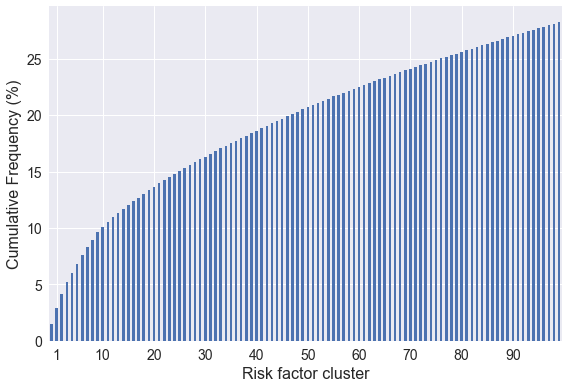

In [10]:
df[:100].plot.bar(fontsize = 14)
plt.ylabel('Frequency (%)', fontsize = 16)
plt.xlabel('Risk factor cluster', fontsize = 16)

a = [1]
a.extend(range(10, 100, 10))
plt.xticks(a, rotation = 0);